# Import Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from keras.utils import plot_model
from keras.preprocessing import image_dataset_from_directory, image
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, Rescaling, RandomRotation, RandomZoom, RandomFlip, RandomContrast 
from keras.regularizers import l2
from keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall, AUC
from keras.callbacks import EarlyStopping
from keras.models import load_model

2025-07-02 19:42:18.511872: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751485338.944410      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751485339.071114      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data Preparation and preprocessing

In [ ]:
dataset_path = '../Teeth DataSet/Teeth_Dataset'
dataset_dir = os.listdir(dataset_path)
print(f'The Dataset directory constists of {dataset_dir} directories.')

The Dataset directory constists of ['Validation', 'Training', 'Testing'] directories.


In [3]:
train_path = dataset_path + '/Training'
val_path = dataset_path + '/Validation'
test_path = dataset_path + '/Testing'

In [4]:
train_dataset = image_dataset_from_directory(
    directory = train_path,           
    labels = "inferred",           
    label_mode = "categorical", 
    image_size = (224, 224),
)

Found 3087 files belonging to 7 classes.


I0000 00:00:1751485360.376078      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751485360.377078      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [5]:
val_dataset = image_dataset_from_directory(
    directory = val_path,           
    labels = "inferred",           
    label_mode = "categorical",  
    image_size = (224, 224),
)

Found 1028 files belonging to 7 classes.


In [6]:
test_dataset = image_dataset_from_directory(
    directory = test_path,           
    labels = "inferred",           
    label_mode = "categorical",   
    image_size = (224, 224),
)

Found 1028 files belonging to 7 classes.


In [7]:
diseases = os.listdir(train_path)
print(f'Labels represent the following teeth diseases: {diseases}.')

Labels represent the following teeth diseases: ['OC', 'CaS', 'OT', 'CoS', 'Gum', 'MC', 'OLP'].


In [8]:
for images, labels in train_dataset.take(1):
    print("Input shape:", images.shape)

Input shape: (32, 224, 224, 3)


## Data Augmentation

In [9]:
data_generator = tf.keras.Sequential([
    RandomRotation(0.15),
    RandomZoom(0.2),
    RandomFlip("horizontal"),
    RandomContrast(0.2)
])

In [10]:
def augment(images, labels):
    return data_generator(images, training=True), labels

## Preprocessing

In [11]:
def preprocess(data, shuffle_size=0, data_type=None):
    data = data.map(lambda x, y: (Rescaling(1./255)(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    if data_type == 'train' and shuffle_size > 0:
        data = data.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
        data = data.shuffle(shuffle_size)
    data = data.cache()
    data = data.prefetch(tf.data.AUTOTUNE)
    return data

# Data Visualization

## Building the functions

- __This include 3 fuctions:__
1. __plot_images():__ Displays an image for each class
2. __plot_class_distribution():__ Plot the class distribution for the Training, Validation and Testing datasets
3. __original_vs_augmented():__ Shows the original and augmented versions of images to visualize the effect of data augmentation

In [12]:
def plot_images(Diseases):
    plt.figure(figsize = (15, 15))
    for i, disease in enumerate(Diseases):
        img_path = train_path + '/' + disease
        img_to_plot = img_path + '/' + os.listdir(img_path)[0]

        img = image.load_img(img_to_plot)
        img_array = image.img_to_array(img) / 255.0

        plt.subplot(1, 7, i + 1)
        plt.imshow(img_array)
        plt.title(disease)
        plt.axis('off')
    plt.show()

In [13]:
def plot_class_distribution(dataset, class_names = diseases, title='Training'):
    label_counts = {}

    for _, labels in dataset.unbatch():
        label = int(np.argmax(labels.numpy()))
        label_counts[label] = label_counts.get(label, 0) + 1

    class_distribution = pd.DataFrame({
        'Class': [class_names[i] for i in label_counts.keys()],
        'Count': list(label_counts.values())
    })

    plt.figure(figsize=(6, 3))
    sns.barplot(data=class_distribution, x='Class', y='Count', palette='magma', width=0.5)
    plt.title(f'{title} Set\'s Class Distribution')
    plt.xticks(rotation=45)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

In [20]:
def original_vs_augmented(original, augmented, class_names=None, labels=None):
    plt.figure(figsize=(15, 6))
    plt.suptitle('Original vs Augmented', fontsize=16)

    for i in range(len(original)):
        # Original
        plt.subplot(2, len(original), i + 1)
        plt.imshow(original[i].numpy().astype("uint8"))
        label = tf.argmax(labels[i]).numpy()
        plt.title(class_names[label])
        plt.axis("off")

        # Augmented
        plt.subplot(2, len(original), i + 1 + len(original))
        plt.imshow((augmented[i].numpy()).astype("uint8"))
        plt.axis("off")

    plt.tight_layout()
    plt.show()


## Plot an image representing each class

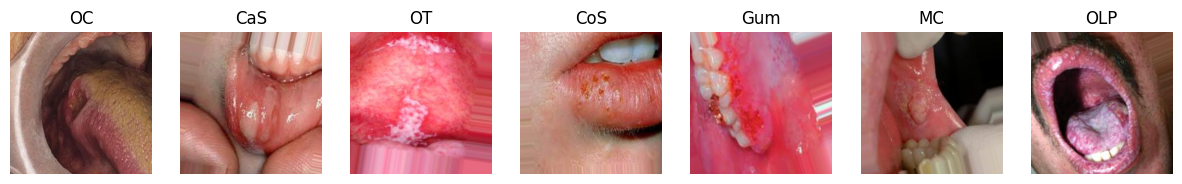

In [15]:
plot_images(diseases)

## Plot Class Distributions

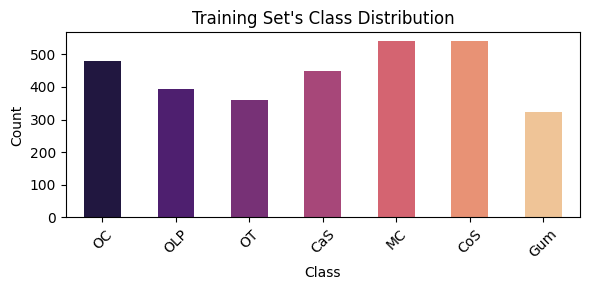

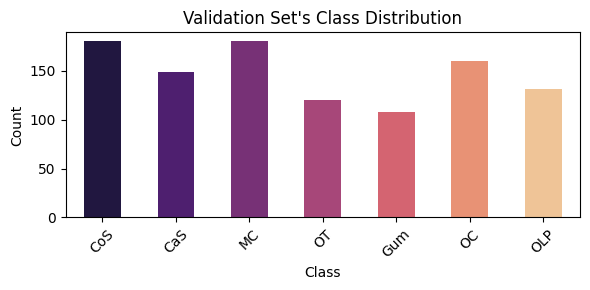

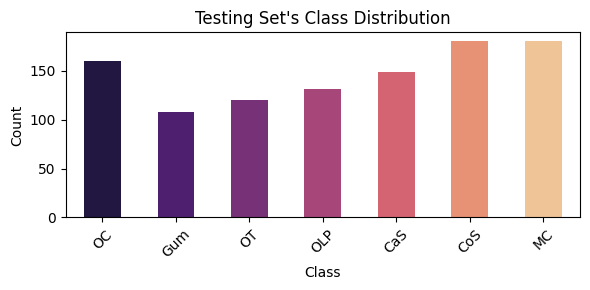

In [16]:
plot_class_distribution(dataset = train_dataset)
plot_class_distribution(dataset = val_dataset, title = 'Validation')
plot_class_distribution(dataset = test_dataset, title = 'Testing')

## Visualize the effect of augmentation

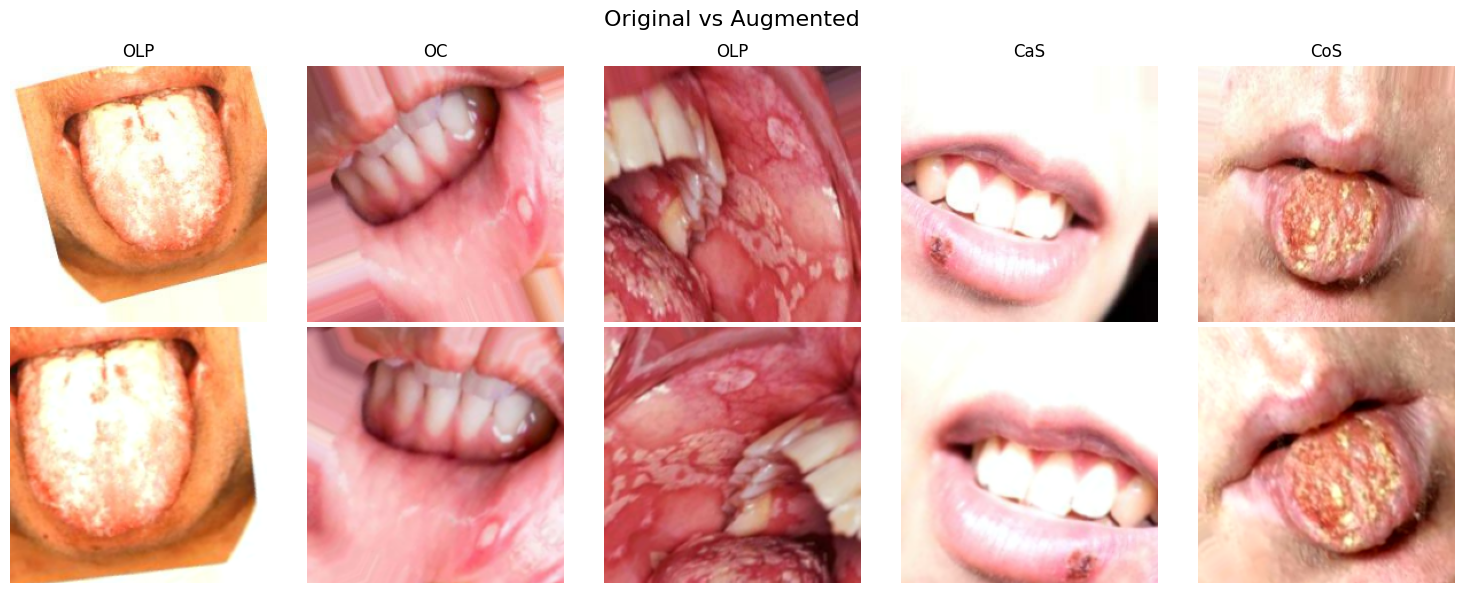

In [21]:
for images, labels in train_dataset.take(1):
    original = images[:5]
    augmented = data_generator(original, training=True)
    original_vs_augmented(original, augmented, diseases, labels) 
    break

# Model Architecture and Training

In [22]:
train_dataset = preprocess(train_dataset, shuffle_size=1000, data_type='train')
val_dataset = preprocess(val_dataset)
test_dataset = preprocess(test_dataset)

- ### Compute the class weights to help with the imbalance

In [24]:
label_list = []
for _, labels in train_dataset.unbatch():
    label_list.append(np.argmax(labels.numpy()))
label_list = np.array(label_list)

class_weights = compute_class_weight('balanced', classes=np.unique(label_list), y=label_list)
class_weights = dict(enumerate(class_weights))

## Build the model

In [ ]:
def Model():
    model = Sequential([
        Conv2D(256, kernel_size=3, activation='relu', 
               kernel_regularizer=l2(0.0001), input_shape=(224, 224, 3)),
        MaxPooling2D(pool_size=2, strides=2, padding='same'),
        BatchNormalization(),

        Conv2D(256, kernel_size=3, activation='relu', kernel_regularizer=l2(0.0001)),
        MaxPooling2D(),
        BatchNormalization(),

        Conv2D(128, kernel_size=3, activation='relu'),
        MaxPooling2D(pool_size=2, strides=2, padding='same'),
        BatchNormalization(),

        Conv2D(128, kernel_size=3, activation='relu'),
        MaxPooling2D(),
  
        Conv2D(64, kernel_size=3, activation='relu'),
        MaxPooling2D(),
        Dropout(0.2),

        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(len(diseases), activation='softmax')
    ])

    model.compile(optimizer=Adamax(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy', 
                       Precision(name='precision'),
                       Recall(name='recall'),
                       AUC(name='auc')])

    return model

In [26]:
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

## Train the model

In [27]:
model = Model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
model_history = model.fit(train_dataset,epochs = 50,validation_data = val_dataset,callbacks=[early_stop], class_weight=class_weights, verbose=1)

Epoch 1/50


I0000 00:00:1751485498.679570     103 service.cc:148] XLA service 0x4de74530 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751485498.680974     103 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751485498.680995     103 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751485499.297093     103 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-07-02 19:45:03.966245: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=0} for conv (f32[32,256,109,109]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,256,111,111]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false

77/97 ━━━━━━━━━━━━━━━━━━━━ 6s 312ms/step - accuracy: 0.1658 - auc: 0.5330 - loss: 2.2683 - precision: 0.1702 - recall: 0.0226

E0000 00:00:1751485560.546234     104 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751485560.867750     104 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


97/97 ━━━━━━━━━━━━━━━━━━━━ 102s 694ms/step - accuracy: 0.1693 - auc: 0.5385 - loss: 2.2199 - precision: 0.1703 - recall: 0.0190 - val_accuracy: 0.1459 - val_auc: 0.5280 - val_loss: 1.9718 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 36s 371ms/step - accuracy: 0.2384 - auc: 0.6127 - loss: 1.9004 - precision: 0.6243 - recall: 0.0091 - val_accuracy: 0.1449 - val_auc: 0.5349 - val_loss: 1.9937 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 35s 365ms/step - accuracy: 0.2674 - auc: 0.6495 - loss: 1.8370 - precision: 0.6721 - recall: 0.0236 - val_accuracy: 0.1479 - val_auc: 0.5440 - val_loss: 2.0046 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 36s 373ms/step - accuracy: 0.3075 - auc: 0.6859 - loss: 1.7812 - precision: 0.6637 - recall: 0.0526 - val_accuracy: 0.1790 - val_auc: 0.5893 - val_loss: 2.0213 - val_precision: 0.3672 - val_recall: 0.0914
Epoch 5/50
97/

# Model Evaluation

In [29]:
train_loss, train_acc, train_prec, train_rec, train_auc = model.evaluate(train_dataset)
val_loss, val_acc, val_prec, val_rec, val_auc = model.evaluate(val_dataset)
test_loss, test_acc, test_prec, test_rec, test_auc = model.evaluate(test_dataset)

97/97 ━━━━━━━━━━━━━━━━━━━━ 16s 166ms/step - accuracy: 0.9678 - auc: 0.9989 - loss: 0.1908 - precision: 0.9818 - recall: 0.9502
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.7814 - auc: 0.9636 - loss: 0.6580 - precision: 0.8328 - recall: 0.7191
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.7860 - auc: 0.9673 - loss: 0.6314 - precision: 0.8201 - recall: 0.7273


In [30]:
print('== Training ==\n' +\
      f'Accuracy: {train_acc:.4f}, Precision: {train_prec:.4f}, Recall: {train_rec:.4f}, AUC: {train_auc:.4f}\n\n' +\
      '== Validation ==\n' +\
      f'Accuracy: {val_acc:.4f}, Precision: {val_prec:.4f}, Recall: {val_rec:.4f}, AUC: {val_auc:.4f}\n\n' +\
      '== Testing ==\n' +\
      f'Accuracy: {test_acc:.4f}, Precision: {test_prec:.4f}, Recall: {test_rec:.4f}, AUC: {test_auc:.4f}'
     )

== Training ==
Accuracy: 0.9627, Precision: 0.9756, Recall: 0.9443, AUC: 0.9986

== Validation ==
Accuracy: 0.7831, Precision: 0.8320, Recall: 0.7179, AUC: 0.9663

== Testing ==
Accuracy: 0.7831, Precision: 0.8243, Recall: 0.7257, AUC: 0.9664


In [31]:
class_map = {i: name for i, name in enumerate(diseases)}
class_map

{0: 'OC', 1: 'CaS', 2: 'OT', 3: 'CoS', 4: 'Gum', 5: 'MC', 6: 'OLP'}

## Build Some functions to help visualize the evaluation

- __This include 4 fuctions:__
1. __Prediction():__ Take a single image and predict its label
2. __Loss_Acc_Evol():__ Plot the model’s training history (loss and accuracy over epochs)
3. __plot_conf_matrix():__ Display the confusion matrix for the test dataset
4. __plot_act_vs_pred():__ Show 25 images with their actual vs predicted labels

In [32]:
def prediction(testing_image_path, actual_label, model, class_map, image_size=(224, 224)):
    img = image.load_img(testing_image_path, target_size=image_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_input = np.expand_dims(img_array, axis=0)  # Shape -> (1, height, width, 3)

    predicted_label = class_map[np.argmax(model.predict(img_input))]

    plt.figure(figsize=(4, 4))
    plt.imshow(img_array)
    plt.title(f'Actual: {actual_label} \nPredicted: {predicted_label}')
    plt.axis('off')
    plt.grid(False)
    plt.show()


In [33]:
def Loss_Acc_Evol(history):
    plt.figure(figsize=(15,6))

    # Plotting the training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss', color='b')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='m')
    plt.legend()
    plt.title('Loss Evolution')
    
    # Plotting the training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='b')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='m')
    plt.legend()
    plt.title('Accuracy Evolution')

    plt.show()

In [34]:
def plot_conf_matrix(model):
    # Extract true labels and predictions from the test_dataset
    y_true = []
    y_pred = []
    
    for images, labels in test_dataset:
        preds = model.predict(images)
        
        y_true.extend(tf.argmax(labels, axis=1).numpy())
        y_pred.extend(tf.argmax(preds, axis=1).numpy())
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Compute the confusion matrix
    cm = tf.math.confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                xticklabels=diseases, yticklabels=diseases)
    
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

In [35]:
def plot_act_vs_pred(model):
    for images, labels in test_dataset.take(1):
        predictions = model.predict(images)
        y_pred_classes = tf.argmax(predictions, axis=1).numpy()
        y_true_classes = tf.argmax(labels, axis=1).numpy()
        break
    
    fig, axes = plt.subplots(5, 5, figsize=(12, 12))
    axes = axes.ravel()
    
    for i in range(25):
        image = (images[i].numpy() * 255).astype("uint8")
        true = diseases[y_true_classes[i]]
        pred = diseases[y_pred_classes[i]]
        color = 'green' if true == pred else 'red'
    
        axes[i].imshow(image)
        axes[i].set_title(f"True: {true}\nPred: {pred}", color=color, fontsize=9)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()


- ### Visualize the loss and accuracy Evolution for Validation and training datasets 

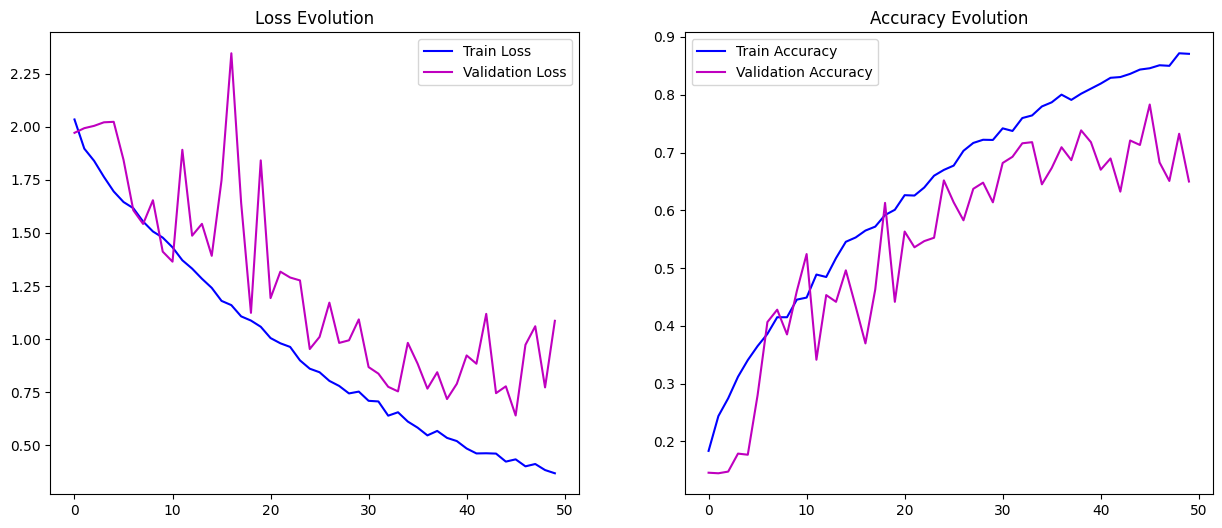

In [36]:
Loss_Acc_Evol(model_history)

- ### Visualize the confusion matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

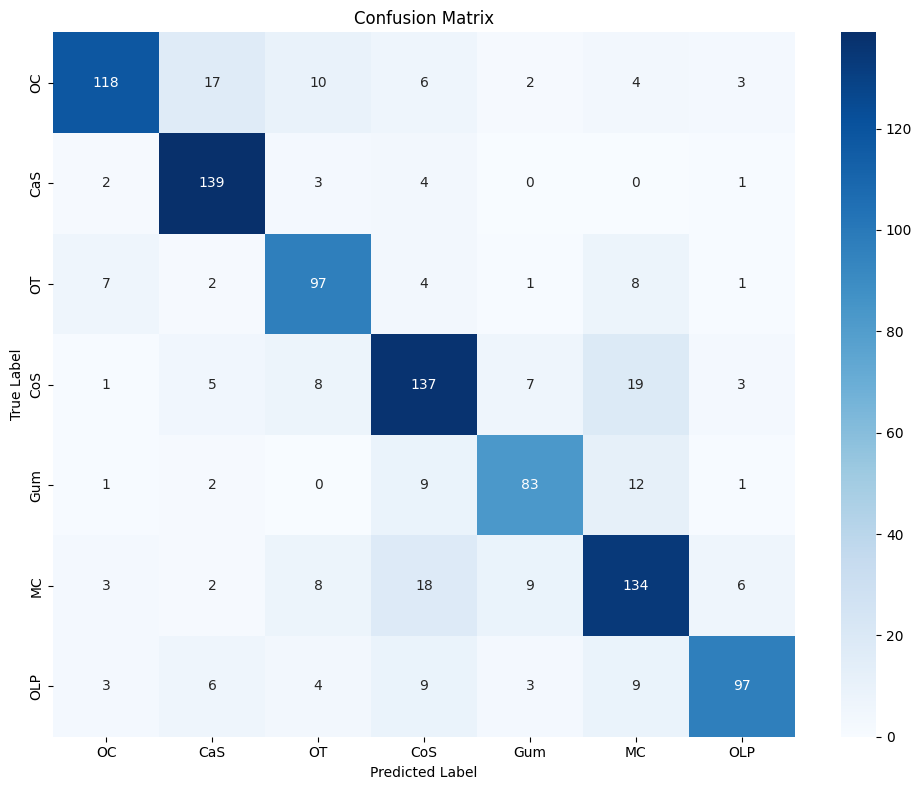

In [37]:
plot_conf_matrix(model)

- ### visualize some samples from test data and predict their label 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


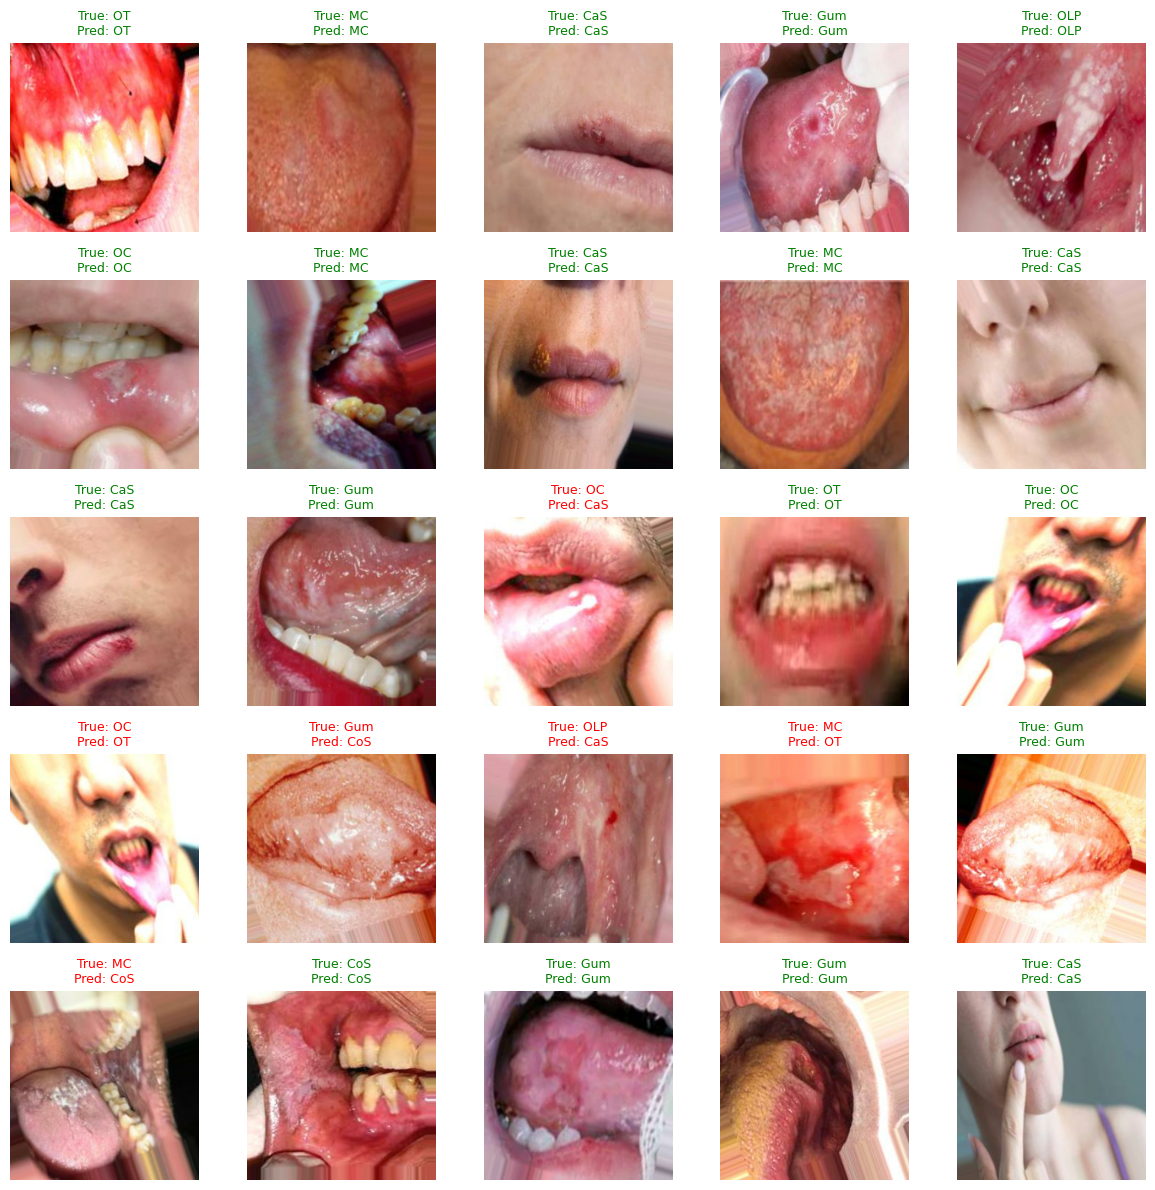

In [38]:
plot_act_vs_pred(model)

## Predict the disease for an image

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


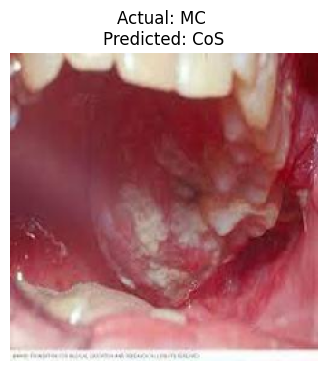

In [40]:
testing_image = '/kaggle/input/teeth-classification-dataset/Teeth_Dataset/Testing/MC/mc_1201.jpg'
prediction(testing_image, actual_label = 'MC', model=model, class_map=class_map)

## Save Model

In [41]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 256)       │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 111, 111, 256)       │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 54, 54, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 26, 26, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 10, 10, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,654,871 (13.94 MB)

 Trainable params: 1,217,863 (4.65 MB)

 Non-trainable params: 1,280 (5.00 KB)

 Optimizer params: 2,435,728 (9.29 MB)

In [42]:
model.save('Model_Teeth_disease_classification.h5')

In [ ]:
plot_model(model, to_file='cnn_model.png', rankdir='TB', show_dtype=True)

In [ ]:
print('===== Model weights =====\n')
for layer in model.layers:
    print(f'Layer: {layer.name} \n' + \
        f'{layer.get_weights()} \n')

===== Model weights =====

Layer: conv2d 
[array([[[[ 0.02792389,  0.04012476, -0.02281872, ..., -0.01557624,
           0.02549267, -0.01570451],
         [ 0.0315006 , -0.06371258, -0.01879966, ..., -0.01073368,
           0.04046798,  0.00832107],
         [-0.01823733,  0.03529844, -0.02755222, ..., -0.00433121,
           0.03319031,  0.02713136]],

        [[ 0.03716882, -0.01814447, -0.02704433, ...,  0.02715057,
           0.00570501,  0.00169076],
         [-0.0306865 ,  0.00385543, -0.03441263, ..., -0.03384439,
          -0.00884783,  0.03319952],
         [-0.05008327, -0.05063709,  0.01513089, ..., -0.01512978,
           0.04226949, -0.02474547]],

        [[-0.00994058, -0.05195307,  0.01017514, ..., -0.01709501,
          -0.02010305,  0.03356884],
         [ 0.02270464,  0.0240868 ,  0.05540088, ..., -0.00083766,
          -0.03153821, -0.03521174],
         [-0.0225839 ,  0.02487045,  0.03724268, ..., -0.01906904,
          -0.01964591, -0.04119319]]],


       [[[-0.